# Customer Segmentaion & Classification - eCommerce Dataset

This dataset (URL: https://www.kaggle.com/datasets/carrie1/ecommerce-data ) from the UCI Machine Learning Repository offers a valuable window into customer behaviour within an online retail setting. It comprises real transaction data from a UK-based retailer specializing in unique gifts, spanning a period from December 1st, 2010, to September 12th, 2011. The dataset presents an opportunity to explore customer segmentation, analyse customer lifetime value, predict customer churn, and delve into product popularity trends. While it represents a single retailer, the insights gained can inform effective marketing strategies across the eCommerce industry.

E-commerce is booming, with sales projected to hit $8.1 trillion by 2026. Traditional customer segmentation struggles to keep pace in this dynamic environment. This project explores advanced techniques like K-means clustering and machine learning algorithms to gain deeper customer insights from big data, and will classify customers based on clustering results allowing businesses to develop more targeted strategies and achieve sustainable growth.

In [133]:
# import libraries

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing, model_selection, metrics
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter

%matplotlib inline


In [2]:
# Initialize Plotly for use in the notebook
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

### Step 1. Load the dataset

In [142]:
df = pd.read_csv('data.csv', encoding="ISO-8859-1")

### Step 2. EDA(Exploratory Data Analysis)

In [143]:
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


#### Overview of each columns
###### ※InvoiceNo    No null values, object data type
###### ※StockCode    No null values, object data type 
###### ※Description  This colunm has some missing values, with 540,455 non-null entries out of 541,909, object data type 
###### ※Quantity     No null values 541909, integer data type 
###### ※InvoiceDate  No null values 541909, already in datetime format  
###### ※UnitPrice    No null values 541909, float data type
###### ※CustomerID   This column has a lot of missing values, 406829 non-null entries out of 541,909, float data type
###### ※Country      No null values 541909, object data type 


In [145]:
#Summary statistics for numerical variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [146]:
df.describe(include='object').T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
InvoiceDate,541909,23260,10/31/2011 14:41,1114
Country,541909,38,United Kingdom,495478


1. Quantity: 
###### - Average transaction contains ~9.55 items, but the range is vast (-80,995 to 80,995). 
###### - Negative values indicate returns/cancellations and need handling. 
###### - A high standard deviation suggests significant spread and potential outliers (large difference between max and 75th percentile).
2. UnitPrice: 
###### - Average price is ~$4.61, but the range is wide (-$11,062.06 to $38,970). 
###### - Negative values likely represent errors and require cleaning. 
###### - Similar to quantity, outliers are likely present (large difference between max and 75th percentile).
3. CustomerID: 
###### - Missing values exist (406,829 non-null entries) and need to be addressed. 
###### - The range (12,346 to 18,287) helps identify unique customers.
4. Transactions: 
###### - There are 25,900 unique invoice numbers, indicating separate transactions. 
###### - The most frequent invoice number (573,585) appears 1,114 times, suggesting a large transaction or multi-item order.
5. Products:
###### - 4,070 unique stock codes represent different products.
###### - The most frequent stock code (85123A) appears 2,313 times.
###### - 4,223 unique product descriptions exist.
###### - The most frequent description ("WHITE HANGING HEART T-LIGHT HOLDER") appears 2,369 times. Missing values require  attention.
6. Countries: 
###### - Transactions originate from 38 countries, with the UK dominating at ~91.4%.

### Step 3. Data preprocessing & cleaning

3-1. handle missing values

In [151]:
# handle missing values 
print('The number of missing values')
print('-----------------------------')
missing_rows = df.isnull().sum()
missing_rows

The number of missing values
-----------------------------


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

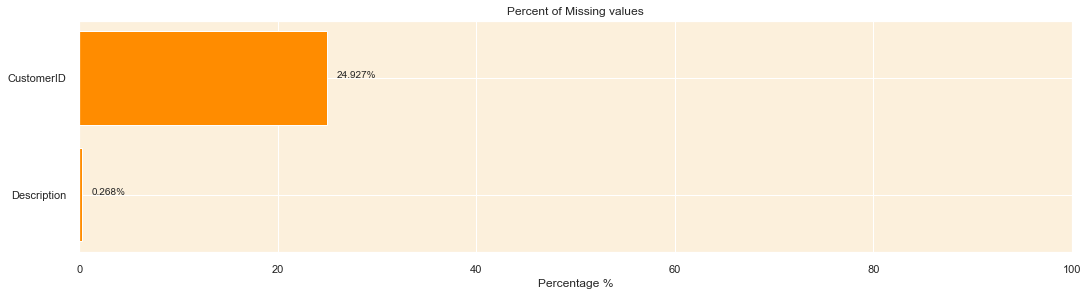

In [152]:
missing_percent = (missing_rows[missing_rows>0] / df.shape[0]) *100
missing_percent.sort_values(ascending=True, inplace=True)
fig,ax = plt.subplots(figsize = (15,4),constrained_layout=True)
ax.barh(missing_percent.index, missing_percent)
ax.set_xlim([0,100])
for i,(percent, col_name) in enumerate(zip(missing_percent,missing_percent.index)):
    ax.text(percent+1,i,f"{percent:.3f}%")
plt.title("Percent of Missing values")
plt.xlabel('Percentage %')
plt.show()

- Missing Values and Data Cleaning

- CustomerID: Many missing values (24.93%) exist, causing issues for clustering and recommendations. Removing rows with missing IDs is preferred to maintain data integrity.
- Description: Few missing values (0.27%) are present. However, inconsistencies exist where the same product code has different descriptions. Removing rows with missing descriptions avoids propagating errors and inconsistencies.

In [153]:
df[df['CustomerID'].isnull()|df['Description'].isnull()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,12/9/2011 10:26,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,12/9/2011 10:26,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,12/9/2011 10:26,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,12/9/2011 10:26,10.79,NaN,United Kingdom


Drop rows with missing values 

In [154]:
df = df.dropna(subset=['CustomerID','Description'])

In [156]:
#Check there's no null value
print('The number of missing values')
print('-----------------------------')
df.isnull().sum()

The number of missing values
-----------------------------


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [158]:
print('The number of rows after eliminating missing values')
print('-----------------------------')
df.shape[0]

The number of rows after eliminating missing values
-----------------------------


406829

3-2. handle duplicate

In [160]:
#find duplicated rows
duplicate_rows = df[df.duplicated(keep=False)]

duplicate_rows_sorted = duplicate_rows.sort_values(by=['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Quantity'])
duplicate_rows_sorted.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom


##### The dataset contains duplicate rows with identical transaction times. These likely represent recording errors, not real repurchases. Keeping them can skew recommendations and clustering.  Removing duplicates will create a cleaner dataset for building accurate customer profiles and product recommendations.

In [161]:
# Display the number of duplicate rows
print(f"The number of duplicated rows: {df.duplicated().sum()} (rows)")

# Removing duplicate rows
df.drop_duplicates(inplace=True)

The number of duplicated rows: 5225 (rows)


In [162]:
print('The number of rows after eliminating duplicated values')
print('------------------------------------------------')
df.shape[0]

The number of rows after eliminating duplicated values
------------------------------------------------


401604

In [17]:
pd.DataFrame([{'products': len(df['StockCode'].value_counts()),    
               'transactions': len(df['InvoiceNo'].value_counts()),
               'customers': len(df['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3684,22190,4372


The number of products purchased in every transaction

In [163]:
tmp = df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = tmp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346.0,541431,1
1,12346.0,C541433,1
2,12347.0,537626,31
3,12347.0,542237,29
4,12347.0,549222,24
5,12347.0,556201,18
6,12347.0,562032,22
7,12347.0,573511,47
8,12347.0,581180,11
9,12348.0,539318,17


3-3. Handle cancelled transaction

In [165]:
# detect cancelled transations
# if 'InvoiceNo' starts with "C", it means cancelled transactions.
# Create new columns for transation_status.'Cancelled' or 'Completed'
df['Transaction_Status'] = np.where(df['InvoiceNo'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancelled_transactions.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Transaction_Status
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom,Cancelled
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom,Cancelled
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom,Cancelled
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom,Cancelled
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom,Cancelled


In [20]:
cancelled_transactions.describe()

,Quantity,UnitPrice,CustomerID
count,8872.000000,8872.000000,8872.000000
mean,-30.774910,18.899512,14990.152953
std,1172.249902,445.190864,1708.230387
min,-80995.000000,0.010000,12346.000000
25%,-6.000000,1.450000,13505.000000
50%,-2.000000,2.950000,14868.000000
75%,-1.000000,4.950000,16393.000000
max,-1.000000,38970.000000,18282.000000


In [167]:
percentage_of_cancelled = (cancelled_transactions.shape[0]/df.shape[0])*100
print(f'percentage_of_cancelled : {percentage_of_cancelled} %')

percentage_of_cancelled : 2.209141343213713 %


- Cancelled Transactions: Insights and Strategy
1. Identification: Transactions with invoice numbers starting with "C" are flagged as cancelled due to negative quantities.
2. Insights: Cancelled transactions involve a variety of products (low to high value).
3. Strategy: Keep cancelled transactions and mark them for distinct analysis. This will: Improve customer clustering by capturing cancellation patterns as potential customer behaviors. Potentially prevent recommending products with high cancellation rates, leading to better recommendations.

3-4. Stockcode Anomalies

In [166]:
number_of_unique_stockcodes = df['StockCode'].nunique()
print(f'The number of unique Stockcodes: {number_of_unique_stockcodes}')

The number of unique Stockcodes: 3684


In [169]:
unique_stockcode_list = df['StockCode'].unique()
char_counts_in_unique_stockcode = pd.Series(unique_stockcode_list).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()
print('Word count of Stockcode')
print('--------------------------------------------')
char_counts_in_unique_stockcode

Word count of Stockcode
--------------------------------------------


5    3676
0       7
1       1
dtype: int64

In [170]:
# Finding and printing the stock codes with 0 and 1 numeric characters
anomalous_stock_codes = [code for code in unique_stockcode_list if sum(c.isdigit() for c in str(code)) in (0, 1)]

# Printing each stock code on a new line
print("Anomalous stock codes:")
print("-"*22)
for code in anomalous_stock_codes:
    print(code)

Anomalous stock codes:
----------------------
POST
D
C2
M
BANK CHARGES
PADS
DOT
CRUK


In [171]:
# Calculating the percentage of records with these stock codes
percentage_anomalous = (df['StockCode'].isin(anomalous_stock_codes).sum() / len(df)) * 100

# Printing the percentage
print(f"The percentage of records with anomalous stock codes in the dataset is: {percentage_anomalous:.2f}%")

The percentage of records with anomalous stock codes in the dataset is: 0.48%


After reviewing the descriptions of the respective codes, it appeared that they did not resemble product codes, and thus were removed. The dataset exhibits anomalies in stock codes, comprising approximately 0.48% of the total records. Following the elimination of these anomalies, the dataset now consists of 399,689 rows.

In [173]:
# Removing rows with anomalous stock codes from the dataset
df = df[~df['StockCode'].isin(anomalous_stock_codes)]
print('The number of rows after eliminating stockcode anomalies')
print('------------------------------------------------')
df.shape[0]

The number of rows after eliminating stockcode anomalies
------------------------------------------------


399689

3-5.Unitprice Anomalies

In [174]:
print('UnitPrice describe')
print('------------------------------------------------')
df['UnitPrice'].describe()

UnitPrice describe
------------------------------------------------


count    399689.000000
mean          2.907457
std           4.451881
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

There are rows with zero unit price

In [28]:
df[df['UnitPrice']==0].describe()

,Quantity,UnitPrice,CustomerID
count,33.000000,33.0,33.000000
mean,420.515152,0.0,14252.575758
std,2176.713608,0.0,1659.811925
min,1.000000,0.0,12415.000000
25%,2.000000,0.0,13081.000000
50%,11.000000,0.0,13985.000000
75%,36.000000,0.0,14911.000000
max,12540.000000,0.0,18059.000000


33 rows with zero UnitPeice, it might occur noise of ML. So, I deleted these rows(33 transactions)

In [175]:
df = df[df['UnitPrice']>0]
print('The number of rows after eliminating UnitPrice anomalies')
print('------------------------------------------------')
df.shape[0]

The number of rows after eliminating UnitPrice anomalies
------------------------------------------------


399656

3-6. Conclusion of Data Cleaning

In [177]:
# Resetting the index of the cleaned dataset
df.reset_index(drop=True, inplace=True)
print('The number of rows after data cleaning')
print('------------------------------------------------')
df.shape[0]

The number of rows after data cleaning
------------------------------------------------


399656

In [31]:
pd.DataFrame([{'products': len(df['StockCode'].value_counts()),    
               'transactions': len(df['InvoiceNo'].value_counts()),
               'customers': len(df['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3676,21785,4362


### Step 4. Feature Engineering

### RFM Feature

R(Recency)
Days Since Last Purchase

In [32]:
# Convert InvoiceDate to datetime type
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
# Convert InvoiceDate to datetime and extract only the date
df['InvoiceDay'] = df['InvoiceDate'].dt.date

# Find the most recent purchase date for each customer
customer_data = df.groupby('CustomerID')['InvoiceDay'].max().reset_index()
# customer_data
# Find the most recent date in the entire dataset
most_recent_date = df['InvoiceDay'].max()
# most_recent_date
# Convert InvoiceDay to datetime type before subtraction
customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)
# Calculate the number of days since the last purchase for each customer
customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days

# Remove the InvoiceDay column
customer_data.drop(columns=['InvoiceDay'], inplace=True)
customer_data

,CustomerID,Days_Since_Last_Purchase
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310
...,...,...
4357,18280.0,277
4358,18281.0,180
4359,18282.0,7
4360,18283.0,3


### F(Frequency)
Total transactions

Total purchased products

In [33]:
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

total_transactions.rename(columns={'InvoiceNo':'total_transactions'},inplace=True)
# total_transaction

total_purchased_products = df.groupby('CustomerID')['Quantity'].nunique().reset_index()
total_purchased_products.rename(columns={'Quantity':'total_purchased_products'},inplace=True)
# total_purchased_products

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_transactions, on='CustomerID')
customer_data = pd.merge(customer_data, total_purchased_products, on='CustomerID')
customer_data.head()


,CustomerID,Days_Since_Last_Purchase,total_transactions,total_purchased_products
0,12346.0,325,2,2
1,12347.0,2,7,15
2,12348.0,75,4,8
3,12349.0,18,1,12
4,12350.0,310,1,4


### M(Monetary)
Total Spend

Mean of Transaction Value

In [34]:
df['total_spend'] = df['UnitPrice']*df['Quantity']
# df.head()
total_spend = df.groupby('CustomerID')['total_spend'].sum().reset_index()
# total_spend.head()

mean_of_transaction = total_spend.merge(total_transactions,on = 'CustomerID')
mean_of_transaction['mean_of_transaction'] = mean_of_transaction['total_spend']/mean_of_transaction['total_transactions']

#merge
customer_data = pd.merge(customer_data, total_spend, on='CustomerID')
customer_data = pd.merge(customer_data, mean_of_transaction[['CustomerID', 'mean_of_transaction']], on='CustomerID')
customer_data.head()


,CustomerID,Days_Since_Last_Purchase,total_transactions,total_purchased_products,total_spend,mean_of_transaction
0,12346.0,325,2,2,0.00,0.000000
1,12347.0,2,7,15,4310.00,615.714286
2,12348.0,75,4,8,1437.24,359.310000
3,12349.0,18,1,12,1457.55,1457.550000
4,12350.0,310,1,4,294.40,294.400000


### Product Diversity
Unique Products Purchased

In [35]:
unique_products_purchased = df.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_products_purchased.head()
unique_products_purchased.rename(columns={'StockCode':'unique_products_purchased'},inplace=True)

customer_data = pd.merge(customer_data, unique_products_purchased, on='CustomerID')
customer_data.head()


,CustomerID,Days_Since_Last_Purchase,total_transactions,total_purchased_products,total_spend,mean_of_transaction,unique_products_purchased
0,12346.0,325,2,2,0.00,0.000000,1
1,12347.0,2,7,15,4310.00,615.714286,103
2,12348.0,75,4,8,1437.24,359.310000,21
3,12349.0,18,1,12,1457.55,1457.550000,72
4,12350.0,310,1,4,294.40,294.400000,16


In [36]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Transaction_Status,InvoiceDay,total_spend
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,Completed,2010-12-01,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Completed,2010-12-01,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,Completed,2010-12-01,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Completed,2010-12-01,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Completed,2010-12-01,20.34
...,...,...,...,...,...,...,...,...,...,...,...
399651,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,Completed,2011-12-09,10.20
399652,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,Completed,2011-12-09,12.60
399653,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,Completed,2011-12-09,16.60
399654,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,Completed,2011-12-09,16.60


### Interval between purchases

In [37]:
interval_between_purchases = df.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = interval_between_purchases.groupby('CustomerID').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)
average_days_between_purchases

,CustomerID,Average_Days_Between_Purchases
0,12346.0,0.000000
1,12347.0,2.016575
2,12348.0,10.884615
3,12349.0,0.000000
4,12350.0,0.000000
...,...,...
4280,18280.0,0.000000
4281,18281.0,0.000000
4282,18282.0,9.916667
4283,18283.0,0.465181


In [38]:
customer_data = pd.merge(customer_data, average_days_between_purchases, on='CustomerID')
customer_data.head()


,CustomerID,Days_Since_Last_Purchase,total_transactions,total_purchased_products,total_spend,mean_of_transaction,unique_products_purchased,Average_Days_Between_Purchases
0,12346.0,325,2,2,0.00,0.000000,1,0.000000
1,12347.0,2,7,15,4310.00,615.714286,103,2.016575
2,12348.0,75,4,8,1437.24,359.310000,21,10.884615
3,12349.0,18,1,12,1457.55,1457.550000,72,0.000000
4,12350.0,310,1,4,294.40,294.400000,16,0.000000


### Cancellation
Cancellation Frequency

Cancellation Rate

In [39]:
# Calculate the total number of transactions made by each customer
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

# Calculate the number of cancelled transactions for each customer
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancellation_freq = cancelled_transactions.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
cancellation_freq.rename(columns={'InvoiceNo': 'cancellation_freq'}, inplace=True)


In [40]:
# Merge the Cancellation Frequency data into the customer_data dataframe
customer_data = pd.merge(customer_data, cancellation_freq, on='CustomerID', how='left')


In [41]:
# Replace NaN values with 0 (for customers who have not cancelled any transaction)
customer_data['cancellation_freq'].fillna(0, inplace=True)
customer_data

,CustomerID,Days_Since_Last_Purchase,total_transactions,total_purchased_products,total_spend,mean_of_transaction,unique_products_purchased,Average_Days_Between_Purchases,cancellation_freq
0,12346.0,325,2,2,0.00,0.000000,1,0.000000,1.0
1,12347.0,2,7,15,4310.00,615.714286,103,2.016575,0.0
2,12348.0,75,4,8,1437.24,359.310000,21,10.884615,0.0
3,12349.0,18,1,12,1457.55,1457.550000,72,0.000000,0.0
4,12350.0,310,1,4,294.40,294.400000,16,0.000000,0.0
...,...,...,...,...,...,...,...,...,...
4280,18280.0,277,1,5,180.60,180.600000,10,0.000000,0.0
4281,18281.0,180,1,4,80.82,80.820000,7,0.000000,0.0
4282,18282.0,7,3,9,176.60,58.866667,12,9.916667,1.0
4283,18283.0,3,16,10,2039.58,127.473750,262,0.465181,0.0


In [42]:
customer_data['cancellation_rate'] = customer_data['cancellation_freq']/total_transactions['InvoiceNo']
customer_data

,CustomerID,Days_Since_Last_Purchase,total_transactions,total_purchased_products,total_spend,mean_of_transaction,unique_products_purchased,Average_Days_Between_Purchases,cancellation_freq,cancellation_rate
0,12346.0,325,2,2,0.00,0.000000,1,0.000000,1.0,0.500000
1,12347.0,2,7,15,4310.00,615.714286,103,2.016575,0.0,0.000000
2,12348.0,75,4,8,1437.24,359.310000,21,10.884615,0.0,0.000000
3,12349.0,18,1,12,1457.55,1457.550000,72,0.000000,0.0,0.000000
4,12350.0,310,1,4,294.40,294.400000,16,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...
4280,18280.0,277,1,5,180.60,180.600000,10,0.000000,0.0,0.000000
4281,18281.0,180,1,4,80.82,80.820000,7,0.000000,0.0,0.000000
4282,18282.0,7,3,9,176.60,58.866667,12,9.916667,1.0,0.166667
4283,18283.0,3,16,10,2039.58,127.473750,262,0.465181,0.0,0.000000


### Step 5. Handle Outlier/ Anomaly Detection

In [43]:
# Initializing the IsolationForest model with a 'auto' contamination
isolation_forest_model = IsolationForest(contamination= 0.05, random_state=0)

# Fitting the model on our dataset (converting DataFrame to NumPy to avoid warning)
customer_data['Outlier_Scores'] = isolation_forest_model.fit_predict(customer_data.iloc[:, 1:].to_numpy())

In [44]:
customer_data[customer_data['Outlier_Scores'] != 1]

,CustomerID,Days_Since_Last_Purchase,total_transactions,total_purchased_products,total_spend,mean_of_transaction,unique_products_purchased,Average_Days_Between_Purchases,cancellation_freq,cancellation_rate,Outlier_Scores
10,12357.0,33,1,15,6207.67,6207.670000,131,0.000000,0.0,0.000000,-1
27,12378.0,129,1,16,4008.62,4008.620000,219,0.000000,0.0,0.000000,-1
50,12409.0,78,7,20,11056.93,1579.561429,91,0.920354,4.0,0.571429,-1
55,12415.0,24,24,56,123638.18,5151.590833,443,0.404916,4.0,0.166667,-1
71,12433.0,0,7,27,13375.87,1910.838571,219,0.890215,0.0,0.000000,-1
...,...,...,...,...,...,...,...,...,...,...,...
4157,18109.0,1,31,26,7877.27,254.105484,120,0.817778,5.0,0.555556,-1
4163,18118.0,10,31,21,5564.63,179.504194,423,0.283570,5.0,5.000000,-1
4209,18183.0,218,6,13,600.52,100.086667,36,1.302326,4.0,4.000000,-1
4238,18223.0,1,26,23,6318.07,243.002692,118,1.202020,12.0,6.000000,-1


When contamination set as 'auto', there were many loss of data, then set as contamination = 0.05

In [45]:
# is_outlier = 1 -> outlier
# is_outlier = 0 -> inlier
customer_data['is_outlier'] = [1 if x == -1 else 0 for x in customer_data['Outlier_Scores']]

In [178]:
customer_data[customer_data['is_outlier'] == 0]

,CustomerID,Days_Since_Last_Purchase,total_transactions,total_purchased_products,total_spend,mean_of_transaction,unique_products_purchased,Average_Days_Between_Purchases,cancellation_freq,cancellation_rate,Outlier_Scores,is_outlier
0,12346.0,325,2,2,0.00,0.000000,1,0.000000,1.0,0.500000,1,0
1,12347.0,2,7,15,4310.00,615.714286,103,2.016575,0.0,0.000000,1,0
2,12348.0,75,4,8,1437.24,359.310000,21,10.884615,0.0,0.000000,1,0
3,12349.0,18,1,12,1457.55,1457.550000,72,0.000000,0.0,0.000000,1,0
4,12350.0,310,1,4,294.40,294.400000,16,0.000000,0.0,0.000000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4280,18280.0,277,1,5,180.60,180.600000,10,0.000000,0.0,0.000000,1,0
4281,18281.0,180,1,4,80.82,80.820000,7,0.000000,0.0,0.000000,1,0
4282,18282.0,7,3,9,176.60,58.866667,12,9.916667,1.0,0.166667,1,0
4283,18283.0,3,16,10,2039.58,127.473750,262,0.465181,0.0,0.000000,1,0


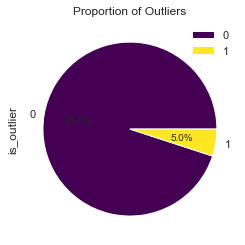

In [179]:
# customer_data[customer_data['Outlier_Scores']== -1]
# Calculate the percentage of inliers and outliers
outlier_percentage = customer_data['is_outlier'].value_counts(normalize=True) * 100
outlier_percentage.plot(kind='pie', autopct='%1.1f%%',title="Title",legend = True,cmap=plt.cm.viridis)
plt.title('Proportion of Outliers')
plt.show()

#### Two approaches were considered:

- Utilizing only the data after outlier removal.
- Utilizing the data with outliers included.
- Ultimately, the decision was made to proceed with outlier removal. 
- When setting the contamination parameter to 'auto', a significant loss of data was observed. Therefore, the contamination parameter was manually set to 0.05 to minimize data loss.

In [180]:
# Remove the outliers from the main dataset
customer_data_cleaned = customer_data[customer_data['is_outlier'] == 0]
# Drop the 'Outlier_Scores' and 'Is_Outlier' columns
customer_data_cleaned = customer_data_cleaned.drop(columns=['Outlier_Scores', 'is_outlier'])
# Reset the index of the cleaned data
customer_data_cleaned.reset_index(drop=True, inplace=True)
customer_data_cleaned.head()

,CustomerID,Days_Since_Last_Purchase,total_transactions,total_purchased_products,total_spend,mean_of_transaction,unique_products_purchased,Average_Days_Between_Purchases,cancellation_freq,cancellation_rate
0,12346.0,325,2,2,0.00,0.000000,1,0.000000,1.0,0.5
1,12347.0,2,7,15,4310.00,615.714286,103,2.016575,0.0,0.0
2,12348.0,75,4,8,1437.24,359.310000,21,10.884615,0.0,0.0
3,12349.0,18,1,12,1457.55,1457.550000,72,0.000000,0.0,0.0
4,12350.0,310,1,4,294.40,294.400000,16,0.000000,0.0,0.0


In [181]:
customer_data_cleaned.describe()

,CustomerID,Days_Since_Last_Purchase,total_transactions,total_purchased_products,total_spend,mean_of_transaction,unique_products_purchased,Average_Days_Between_Purchases,cancellation_freq,cancellation_rate
count,4070.000000,4070.000000,4070.000000,4070.000000,4070.000000,4070.000000,4070.000000,4070.000000,4070.000000,4070.000000
mean,15301.870516,92.087469,3.922604,10.106634,1137.301585,297.810125,54.991400,2.869348,0.547174,0.238303
std,1717.051283,99.223942,3.890130,5.211424,1425.662444,249.798384,58.185014,5.733979,0.995991,0.529665
min,12346.000000,0.000000,1.000000,1.000000,-811.860000,-811.860000,1.000000,0.000000,0.000000,0.000000
25%,13823.250000,18.000000,1.000000,6.000000,292.527500,152.376948,16.000000,0.000000,0.000000,0.000000
50%,15303.500000,51.000000,2.000000,9.000000,622.340000,235.154111,34.000000,1.201027,0.000000,0.000000
75%,16776.750000,142.000000,5.000000,13.000000,1424.127500,362.516667,73.000000,3.142857,1.000000,0.200000
max,18287.000000,373.000000,39.000000,34.000000,15477.340000,4366.780000,445.000000,96.333333,9.000000,4.000000


In [50]:
customer_data_cleaned.shape

(4070, 10)

### Correlation analysis

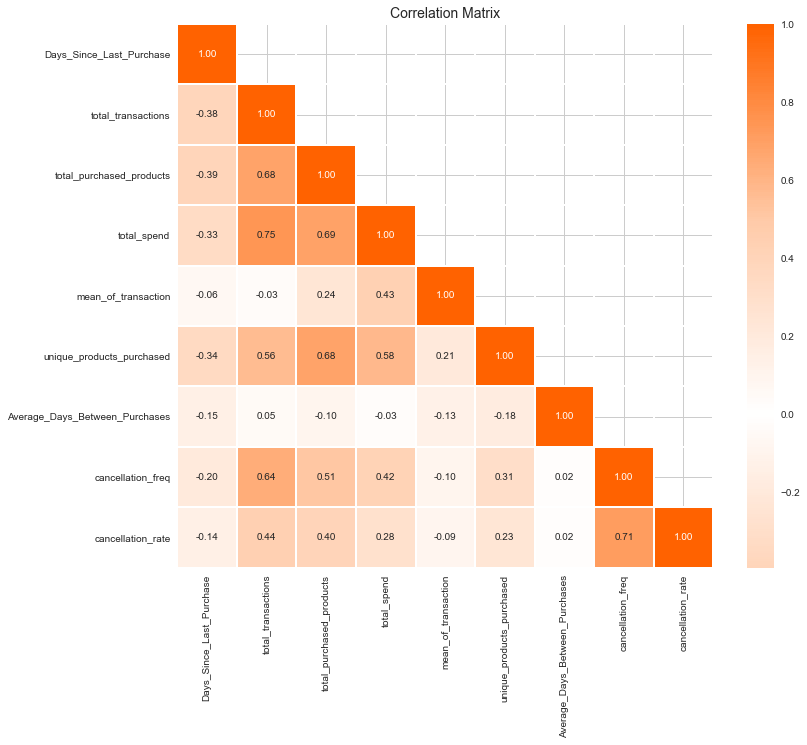

In [51]:
# Calculate the correlation matrix excluding the 'CustomerID' column
corr = customer_data_cleaned.drop(columns=['CustomerID']).corr()
# Define a custom colormap
colors = ['#ff6200', '#ffcaa8', 'white', '#ffcaa8', '#ff6200']
linear_segmented_color_map = LinearSegmentedColormap.from_list('custom_map',colors=colors, N=256)
# Create a mask to only show the lower triangle of the matrix (since it's mirrored around its 
# top-left to bottom-right diagonal)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap=linear_segmented_color_map, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

- Examining the heatmap, it's evident that certain pairs of variables exhibit strong correlations. Notably:

- Total spend and total transactions
- Cancellation frequency and cancellation rate

- These correlations are significant.

### Step 6. Feature Scailing
#### PCA Benefits:
- Address multicollinearity by eliminating redundant features.
- Improve K-means clustering accuracy by simplifying data.
- Filter out noise, leading to more stable clusters.
- Enhance visualization of customer segments.
- Speed up computational processes for increased efficiency.


- + except Customer ID, I'll nomarlize all of features to have mean of 0 and standard deviation of 1. 

In [182]:
# Initialize the StandardScaler
standard_scaler = StandardScaler()

# exclude 'Customer ID'
columns_to_scale = customer_data_cleaned.columns.difference(['CustomerID'])

# Copy the cleaned dataset
scaled_customer_data = customer_data_cleaned.copy()

# Applying the scaler to the necessary columns in the dataset
scaled_customer_data[columns_to_scale] = standard_scaler.fit_transform(scaled_customer_data[columns_to_scale])
scaled_customer_data.head()

,CustomerID,Days_Since_Last_Purchase,total_transactions,total_purchased_products,total_spend,mean_of_transaction,unique_products_purchased,Average_Days_Between_Purchases,cancellation_freq,cancellation_rate
0,12346.0,2.347630,-0.494287,-1.555742,-0.797834,-1.192348,-0.928040,-0.500473,0.454704,0.494141
1,12347.0,-0.908032,0.791175,0.939084,2.225694,1.272799,0.825204,-0.148741,-0.549444,-0.449968
2,12348.0,-0.172232,0.019898,-0.404284,0.210411,0.246228,-0.584267,1.398026,-0.549444,-0.449968
3,12349.0,-0.746761,-0.751379,0.363355,0.224659,4.643274,0.292355,-0.500473,-0.549444,-0.449968
4,12350.0,2.196439,-0.751379,-1.171922,-0.591308,-0.013653,-0.670210,-0.500473,-0.549444,-0.449968


### PCA

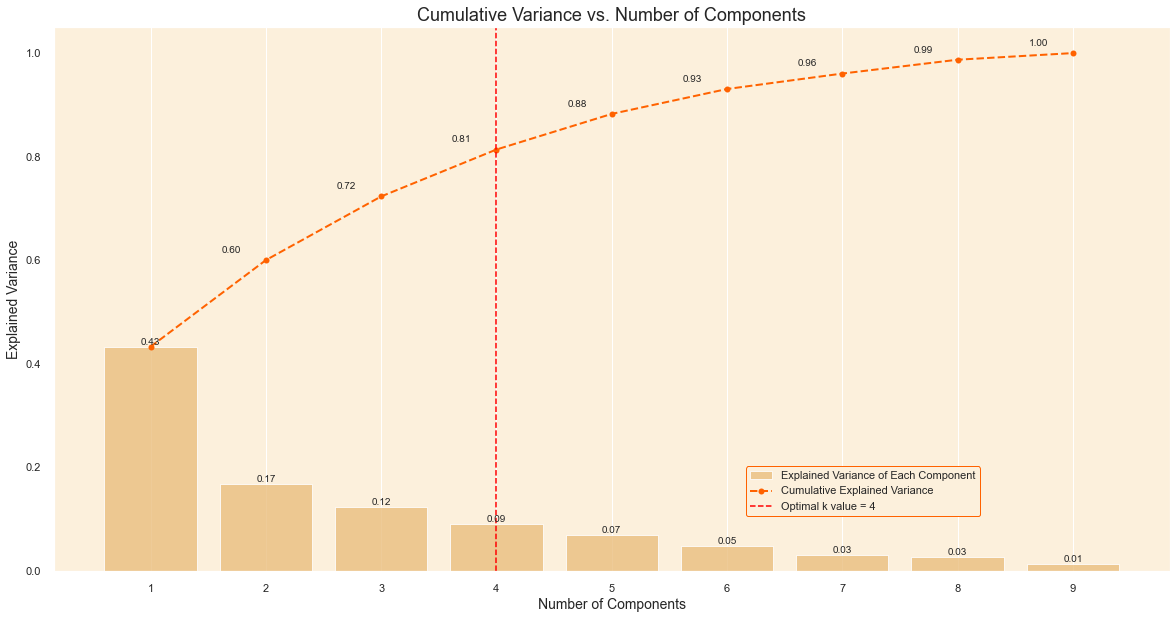

In [53]:
# Setting CustomerID as the index column
scaled_customer_data.set_index('CustomerID', inplace=True)

# Apply PCA
pca = PCA().fit(scaled_customer_data)

# Calculate the Cumulative Sum of the Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Set the optimal k value (based on our analysis, we can choose 6)
optimal_k = 4

# Set seaborn plot style
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

# Plot the cumulative explained variance against the number of components
plt.figure(figsize=(20, 10))

# Bar chart for the explained variance of each component
barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                      y=explained_variance_ratio,
                      color='#fcc36d',
                      alpha=0.8)

# Line plot for the cumulative explained variance
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--', color='#ff6200', linewidth=2)

# Plot optimal k value line
optimal_k_line = plt.axvline(optimal_k - 1, color='red', linestyle='--', label=f'Optimal k value = {optimal_k}') 

# Set labels and title
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

# Customize ticks and legend
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
           labels=['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Optimal k value = {optimal_k}'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,  
           edgecolor='#ff6200')  

# Display the variance values for both graphs on the plots
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')   
plt.show()

#### Conclusion
- The plot and cumulative explained variance values illustrate how each principal component contributes to capturing the dataset's total variance. Notably, the first component explains around 43% of the variance, while the first two components together explain about 43%. As we add components, the cumulative variance increases, with a notable slowdown after the 4th component, capturing approximately 81% of the total variance. Retaining these first 4 components strikes a balance, effectively reducing dimensionality while retaining sufficient information for customer segmentation.

In [54]:
# Creating a PCA object with 6 components
pca = PCA(n_components=4)

# Fitting and transforming the original data to the new PCA dataframe
customer_data_pca = pca.fit_transform(scaled_customer_data)

# Creating a new dataframe from the PCA dataframe, with columns labeled PC1, PC2, etc.
customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# Adding the CustomerID index back to the new PCA dataframe
customer_data_pca.index = scaled_customer_data.index

In [55]:
customer_data_pca.head()

,PC1,PC2,PC3,PC4
CustomerID,,,,
12346.0,-1.979462,-1.629346,-1.929271,0.595180
12347.0,2.037460,2.070753,0.821722,0.167808
12348.0,-0.592998,-0.003706,1.448028,0.687577
12349.0,0.387359,3.752023,0.302629,2.005438
12350.0,-2.223625,0.128198,-1.370702,0.732407


### Step 7. K-means clustering

#### To determine the optimal number of clusters (k) for customer segmentation, I will employ two well-known methods: the Elbow Method and the Silhouette Method. Utilizing both methods is a common practice to validate results.

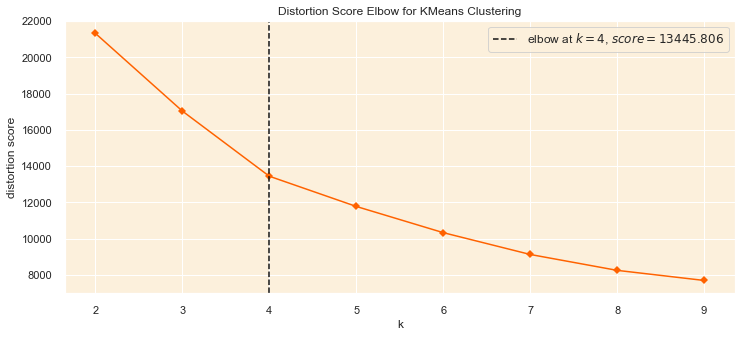

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [183]:
# Set plot style, and background color
sns.set_theme(style='darkgrid', rc={'axes.facecolor': '#fcf0dc'})

# Set the color palette for the plot
sns.set_palette(['#ff6200'])

# Instantiate the clustering model with the specified parameters
km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0)
# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(12, 5))

# Instantiate the KElbowVisualizer with the model and range of k values, and disable the timing plot
visualizer = KElbowVisualizer(km, k=(2, 10), timings=False, ax=ax)

# Fit the data to the visualizer
visualizer.fit(customer_data_pca)

# Finalize and render the figure
visualizer.show()

#### The Elbow Method suggests an optimal k value of 4 for the KMeans clustering algorithm, although the elbow point is not very distinct, which is common in real-world data. Inertia continues to decrease notably up to k=5, indicating the optimal k could be between 3 and 7. 

In [184]:
def silhouette_analysis(df, start_k, stop_k, figsize=(15, 16)):
    """
    Perform Silhouette analysis for a range of k values and visualize the results.
    """

    # Set the size of the figure
    plt.figure(figsize=figsize)

    # Create a grid with (stop_k - start_k + 1) rows and 2 columns
    grid = gridspec.GridSpec(stop_k - start_k + 1, 2)

    # Assign the first plot to the first row and both columns
    first_plot = plt.subplot(grid[0, :])

    # First plot: Silhouette scores for different k values
    sns.set_palette(['darkorange'])

    silhouette_scores = []

    # Iterate through the range of k values
    for k in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=0)
        km.fit(df)
        labels = km.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)

    best_k = start_k + silhouette_scores.index(max(silhouette_scores))

    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)

    # Add the optimal k value text to the plot
    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom', 
             horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))
             

    # Second plot (subplot): Silhouette plots for each k value
    colors = sns.color_palette("bright")

    for i in range(start_k, stop_k + 1):    
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
        row_idx, col_idx = divmod(i - start_k, 2)

        # Assign the plots to the second, third, and fourth rows
        ax = plt.subplot(grid[row_idx + 1, col_idx])

        visualizer = SilhouetteVisualizer(km, colors=colors, ax=ax)
        visualizer.fit(df)

        # Add the Silhouette score text to the plot
        score = silhouette_score(df, km.labels_)
        ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', fontsize=12, \
                ha='right', transform=ax.transAxes, color='red')

        ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)

    plt.tight_layout()
    plt.show()

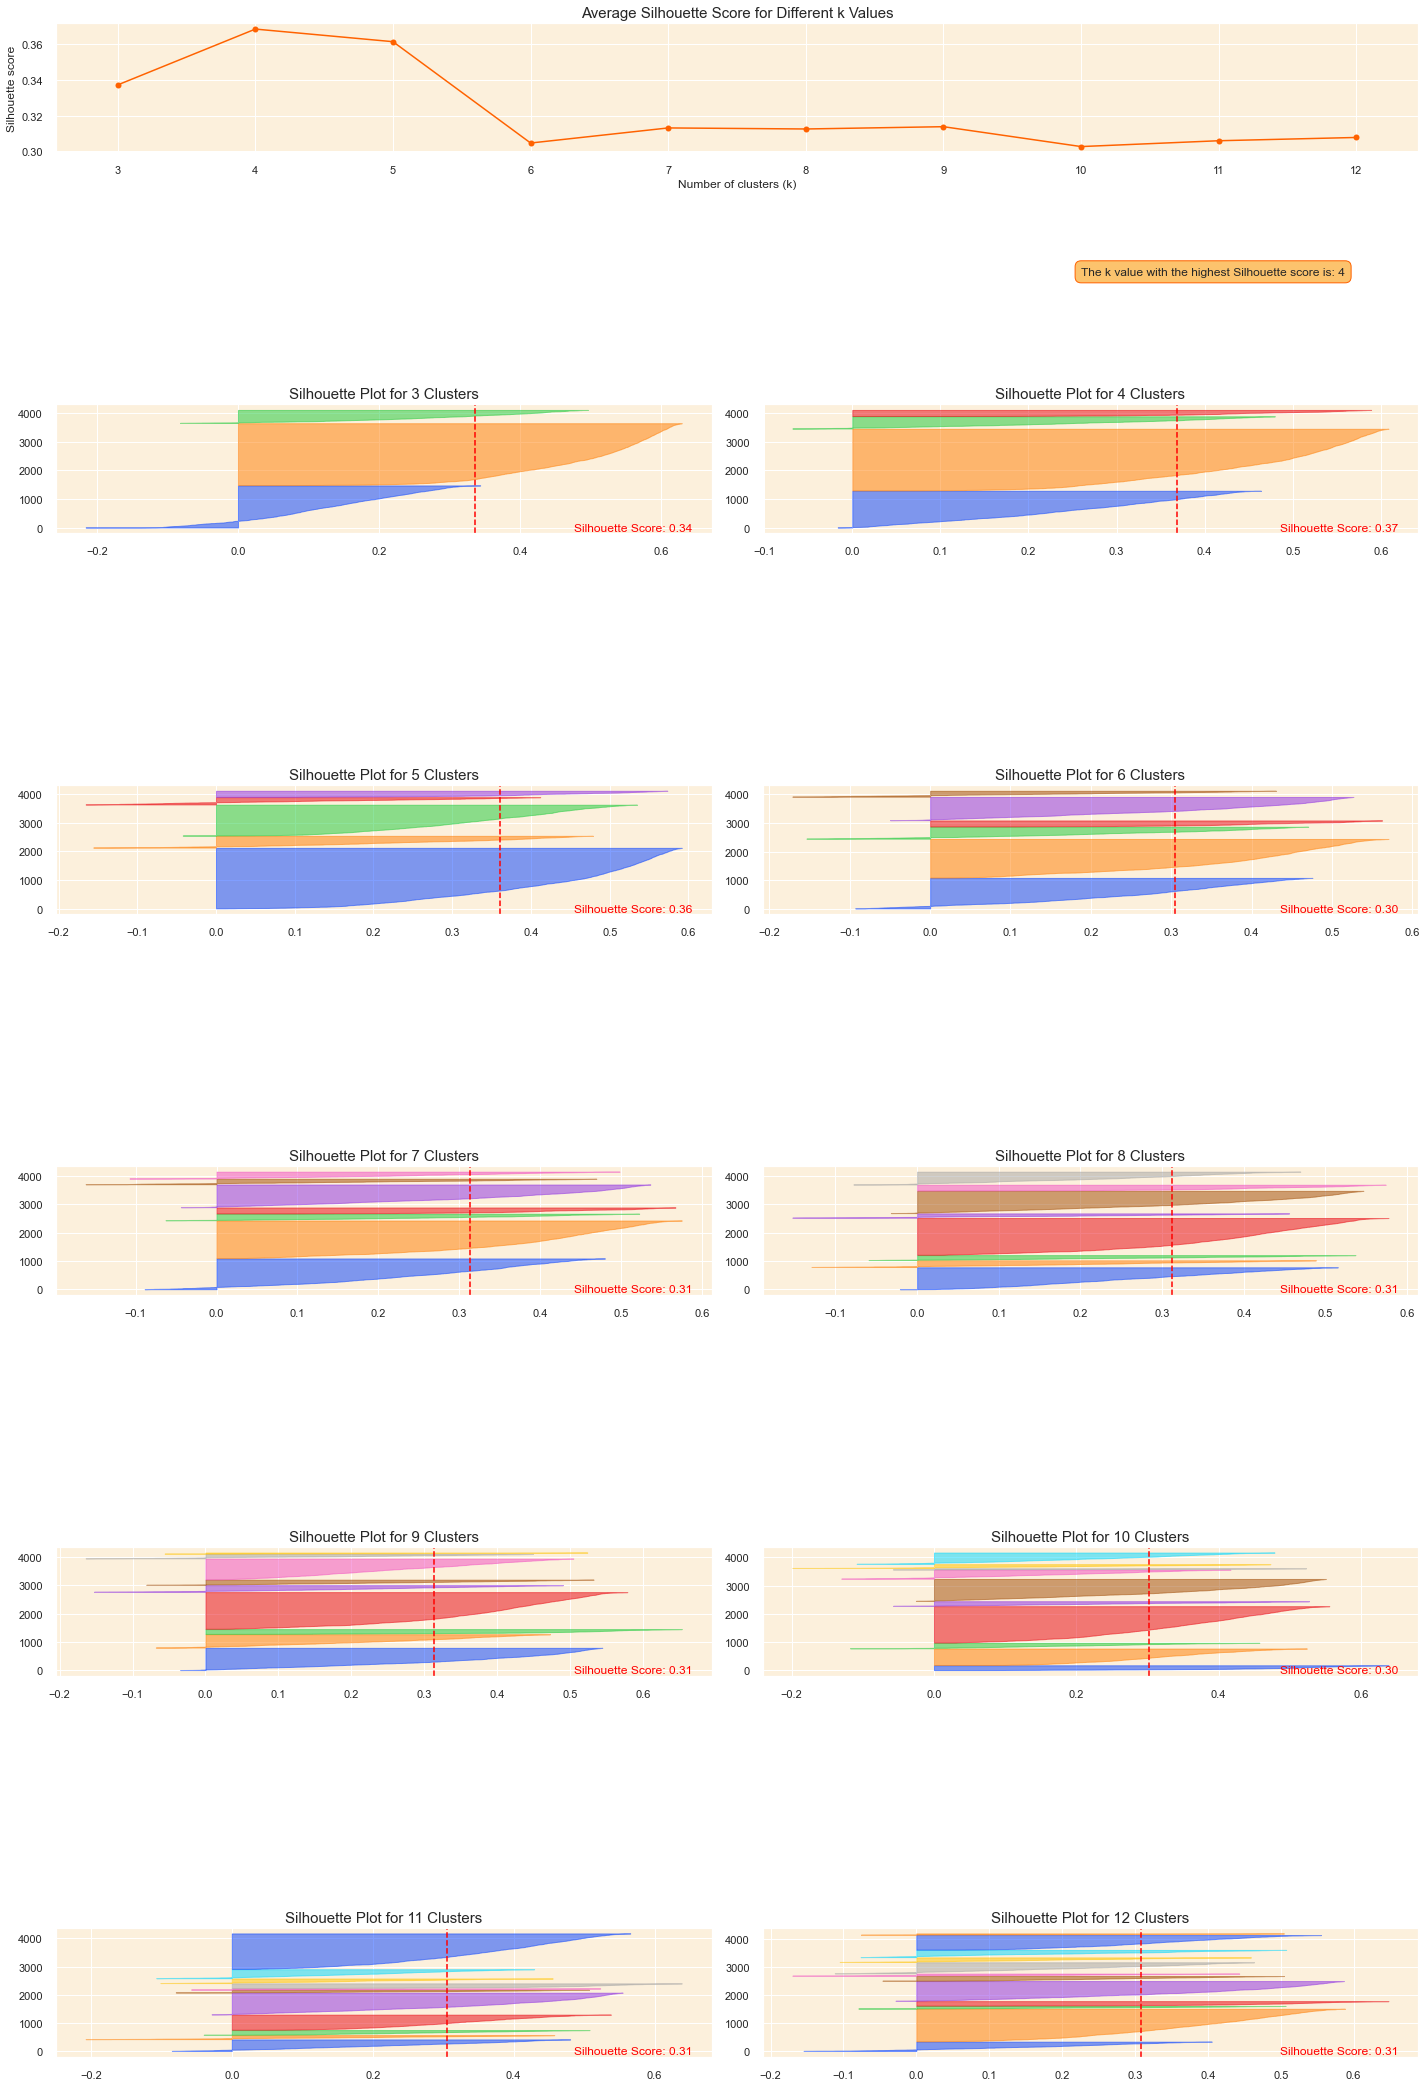

In [185]:
silhouette_analysis(customer_data_pca, 3, 12, figsize=(20, 50))

#### To interpret silhouette plots and determine the optimal number of clusters (k), consider the following guidelines: analyze silhouette score widths (wide indicates well-separated clusters, narrow indicates poorly defined clusters), assess uniformity in cluster size, look for clear peaks in average silhouette scores, minimize fluctuations in silhouette plot widths, maximize the overall average silhouette score, and visually inspect silhouette plots for consistent cluster formation and compactness. Based on these guidelines, selecting k=4 is preferable, as it yields more balanced and well-defined clusters, strengthening the clustering solution.

In [62]:
# Apply KMeans clustering using the optimal k
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(customer_data_pca)

# Get the frequency of each cluster
cluster_frequencies = Counter(kmeans.labels_)

# cluster_frequencies
# Create a mapping from old labels to new labels based on frequency
label_mapping = {label: new_label for new_label, (label, _) in 
                 enumerate(cluster_frequencies.most_common())}

label_mapping


{0: 0, 2: 1, 1: 2, 3: 3}

In [63]:
# Reverse the mapping to assign labels as per your criteria
label_mapping = {v: k for k, v in {0: 0, 2: 1, 1: 2, 3: 3}.items()}

# Apply the mapping to get the new labels
new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

# Append the new cluster labels back to the original dataset
customer_data_cleaned['cluster'] = new_labels

# Append the new cluster labels to the PCA version of the dataset
customer_data_pca['cluster'] = new_labels

In [65]:
# Display the first few rows of the original dataframe
customer_data_cleaned

,CustomerID,Days_Since_Last_Purchase,total_transactions,total_purchased_products,total_spend,mean_of_transaction,unique_products_purchased,Average_Days_Between_Purchases,cancellation_freq,cancellation_rate,cluster
0,12346.0,325,2,2,0.00,0.000000,1,0.000000,1.0,0.500000,0
1,12347.0,2,7,15,4310.00,615.714286,103,2.016575,0.0,0.000000,1
2,12348.0,75,4,8,1437.24,359.310000,21,10.884615,0.0,0.000000,0
3,12349.0,18,1,12,1457.55,1457.550000,72,0.000000,0.0,0.000000,1
4,12350.0,310,1,4,294.40,294.400000,16,0.000000,0.0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...
4065,18280.0,277,1,5,180.60,180.600000,10,0.000000,0.0,0.000000,0
4066,18281.0,180,1,4,80.82,80.820000,7,0.000000,0.0,0.000000,0
4067,18282.0,7,3,9,176.60,58.866667,12,9.916667,1.0,0.166667,3
4068,18283.0,3,16,10,2039.58,127.473750,262,0.465181,0.0,0.000000,1


### Clustring Evaluation

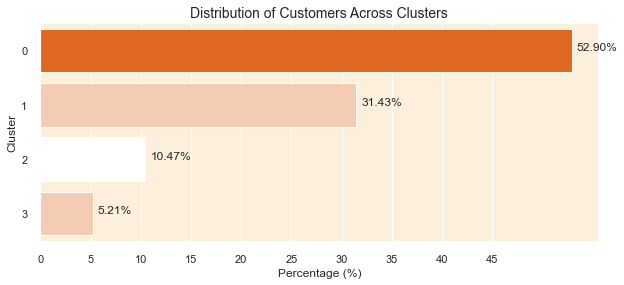

In [186]:
# Calculate the percentage of customers in each cluster
cluster_percentage = (customer_data_pca['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

# Create a horizontal bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)

# Adding percentages on the bars
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

# Show the plot
plt.show()

- Evaluation Metrics

1. Silhouette Score: Measures cluster separation distance, with higher values indicating better separation, ranging from -1 to 1.
2. Calinski-Harabasz Score: Evaluates dispersion within and between clusters, with higher scores indicating better-defined clusters.
3. Davies-Bouldin Score: Assesses average similarity between each cluster and its most similar cluster, with lower values indicating better cluster separation.

In [187]:
# Compute number of customers
num_observations = len(customer_data_pca)

# Separate the features and the cluster labels
X = customer_data_pca.drop('cluster', axis=1)
clusters = customer_data_pca['cluster']

# Compute the metrics
sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)

# Create a table to display the metrics and the number of observations
table_data = [
    ["Number of Observations", num_observations],
    ["Silhouette Score", sil_score],
    ["Calinski Harabasz Score", calinski_score],
    ["Davies Bouldin Score", davies_score]
]

# Print the table
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt='pretty'))

+-------------------------+--------------------+
|         Metric          |       Value        |
+-------------------------+--------------------+
| Number of Observations  |        4070        |
|    Silhouette Score     | 0.3191845402792857 |
| Calinski Harabasz Score | 1649.1437815911315 |
|  Davies Bouldin Score   | 1.1232106863962428 |
+-------------------------+--------------------+


In [191]:
customer_data_pca.to_csv('customer_data.csv')

In [192]:
customer_data_pca

,PC1,PC2,PC3,PC4,cluster
CustomerID,,,,,
12346.0,-1.979462,-1.629346,-1.929271,0.595180,0
12347.0,2.037460,2.070753,0.821722,0.167808,1
12348.0,-0.592998,-0.003706,1.448028,0.687577,0
12349.0,0.387359,3.752023,0.302629,2.005438,1
12350.0,-2.223625,0.128198,-1.370702,0.732407,0
...,...,...,...,...,...
18280.0,-2.175637,-0.164592,-1.204919,0.320739,0
18281.0,-2.105025,-0.434415,-0.680137,-0.322086,0
18282.0,-0.543712,-1.425551,1.282468,-0.253165,3


### Step 10. Customer Classification
1. SVM classifier
2. Random Forest

### SVC

In [195]:
X = customer_data_pca.drop(['cluster'], axis=1)
y = customer_data_pca['cluster']

# Train data set split fo cross-validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


In [196]:
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(X_train, y_train) 

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.914 total time=   0.1s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.937 total time=   0.1s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.939 total time=   0.1s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.926 total time=   0.1s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.926 total time=   0.1s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.955 total time=   0.1s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.965 total time=   0.1s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.980 total time=   0.2s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.975 total time=   0.2s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.967 total time=   0.2s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.871 total time=   0.3s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [197]:
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=1000, gamma=0.01)


In [198]:
grid_predictions = grid.predict(X_test) 
# print classification report 
print(classification_report(y_test, grid_predictions)) 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       871
           1       0.99      0.99      0.99       489
           2       0.99      0.98      0.99       172
           3       0.99      0.98      0.98        96

    accuracy                           0.99      1628
   macro avg       0.99      0.99      0.99      1628
weighted avg       0.99      0.99      0.99      1628



In [211]:
#cross validation
scores = cross_val_score(grid, X, y, scoring='accuracy', cv=3)
print('Accuracy of cross validation\n', np.round(scores,4))
print('Avearge validation Accuracy\n', np.round(np.mean(scores),4))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.928 total time=   0.5s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.924 total time=   0.4s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.937 total time=   0.5s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.943 total time=   0.4s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.946 total time=   0.5s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.967 total time=   0.3s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.952 total time=   0.3s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.959 total time=   0.3s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.982 total time=   0.3s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.967 total time=   0.3s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.912 total time=   0.8s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

Confusion matrix, without normalization
[[868   3   0   0]
 [  2 484   2   1]
 [  1   2 169   0]
 [  1   1   0  94]]
Normalized confusion matrix
[[0.99655568 0.00344432 0.         0.        ]
 [0.00408998 0.98977505 0.00408998 0.00204499]
 [0.00581395 0.01162791 0.98255814 0.        ]
 [0.01041667 0.01041667 0.         0.97916667]]


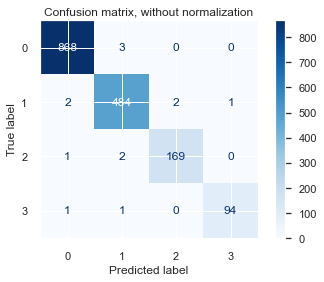

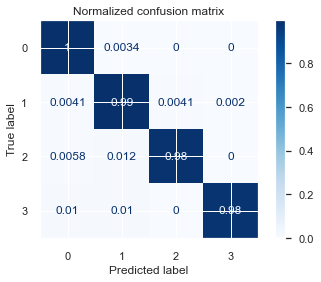

In [199]:
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = metrics.ConfusionMatrixDisplay.from_estimator(
        grid,
        X_test,
        y_test,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

### Random Forest

In [200]:
rfc=RandomForestClassifier(random_state=42)

We will now try adjusting the following set of hyperparameters of this model:

- Max_depth: This hyperparameter represents the maximum level of each tree in the random forest model. A deeper tree performs well and captures a lot of information about the training data, but will not generalize well to test data. By default, this value is set to “None” in the Scikit-Learn library, which means that the trees are left to expand completely.
- Max_features: The maximum number of features that the random forest model is allowed to try at each split. By default in Scikit-Learn, this value is set to the square root of the total number of variables in the dataset.
- N_estimators: The number of decision trees in the forest. The default number of estimators in Scikit-Learn is 10.
- Min_samples_leaf: The minimum number of samples required to be at the leaf node of each tree. The default value is 1 in Scikit-Learn.
- Min_samples_split: The minimum number of samples required to split an internal node of each tree. The default value is 2 in Scikit-Learn.

In [207]:
grid_space={'max_depth':[None],
              'n_estimators':[10,100,200],
           }

In [208]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=grid_space, cv= 5,refit= True)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'n_estimators': [10, 100, 200]})

In [209]:
# print best parameter after tuning 
print(CV_rfc.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(CV_rfc.best_estimator_) 

{'max_depth': None, 'n_estimators': 100}
RandomForestClassifier(random_state=42)


In [210]:
grid_rfc_predictions = CV_rfc.predict(X_test) 
# print classification report 
print(classification_report(y_test, grid_rfc_predictions)) 

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       871
           1       0.95      0.96      0.95       489
           2       0.95      0.97      0.96       172
           3       0.97      0.88      0.92        96

    accuracy                           0.97      1628
   macro avg       0.96      0.95      0.95      1628
weighted avg       0.97      0.97      0.97      1628



In [213]:
#cross validation
scores = cross_val_score(CV_rfc, X, y, scoring='accuracy', cv=3)
print('Accuracy of cross validation\n', np.round(scores,4))
print('Avearge validation Accuracy\n', np.round(np.mean(scores),4))

Accuracy of cross validation
 [0.9727 0.972  0.9779]
Avearge validation Accuracy
 0.9742


Confusion matrix, without normalization
[[854  16   0   1]
 [ 11 467   9   2]
 [  0   5 167   0]
 [  6   6   0  84]]
Normalized confusion matrix
[[0.9804822  0.01836969 0.         0.00114811]
 [0.02249489 0.95501022 0.01840491 0.00408998]
 [0.         0.02906977 0.97093023 0.        ]
 [0.0625     0.0625     0.         0.875     ]]


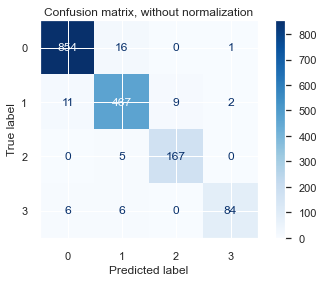

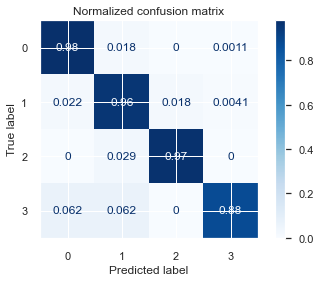

In [212]:
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = metrics.ConfusionMatrixDisplay.from_estimator(
        CV_rfc,
        X_test,
        y_test,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()